### Importar Librerías

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pmdarima import auto_arima
from prophet import Prophet
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


### Cargar datos y agregar por mes

In [ ]:
import pandas as pd

df = pd.read_csv("../output/dataset_farmacia_agrupado.csv", parse_dates=["fecha"])
df = df.set_index('fecha')


14815

In [62]:
ventas_mensuales = df['total_venta'].resample('M').sum()
print(ventas_mensuales.head())

fecha
2019-01-31    72601.05
2019-02-28    71146.50
2019-03-31    75268.00
2019-04-30    73140.60
2019-05-31    73396.10
Freq: ME, Name: total_venta, dtype: float64


### Split train/test 80/20

In [63]:
n = len(ventas_mensuales)
train_size = int(n * 0.7)
val_size = int(n * 0.15)

train = ventas_mensuales[:train_size]
val = ventas_mensuales[train_size:train_size + val_size]
test = ventas_mensuales[train_size + val_size:]

trainval = pd.concat([train, val])
trainval = trainval.asfreq('M')

print(f"Train: {len(train)} registros")
print(f"Validation: {len(val)} registros")
print(f"Test: {len(test)} registros")

Train: 56 registros
Validation: 12 registros
Test: 12 registros


# 1. SARIMA

In [52]:
sarima_model = auto_arima(
    y_train,
    seasonal=True,
    m=12,  # estacionalidad mensual (12 meses por año)
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore'
)

print(sarima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   64
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -684.737
Date:                Mon, 10 Nov 2025   AIC                           1371.474
Time:                        06:27:32   BIC                           1373.617
Sample:                    01-31-2019   HQIC                          1372.317
                         - 04-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.589e+08    1.6e+07      9.931      0.000    1.28e+08     1.9e+08
Ljung-Box (L1) (Q):                   3.06   Jarque-Bera (JB):                44.49
Prob(Q):                              0.08   Pr

In [53]:
sarima_pred = pd.Series(
    sarima_model.predict(n_periods=len(y_test)),
    index=y_test.index
)

print("MSE:", mean_squared_error(y_test, sarima_pred))
print("MAE:", mean_absolute_error(y_test, sarima_pred))
print("R2 :", r2_score(y_test, sarima_pred))

MSE: 47789350.08343749
MAE: 5135.871249999998
R2 : -0.24683200738590405


In [54]:
forecast_periods = 12

sarima_forecast = pd.Series(
    sarima_model.predict(n_periods=forecast_periods),
    index=pd.date_range(
        start=y.index[-1] + pd.offsets.MonthEnd(1),
        periods=forecast_periods,
        freq='M'
    )
)


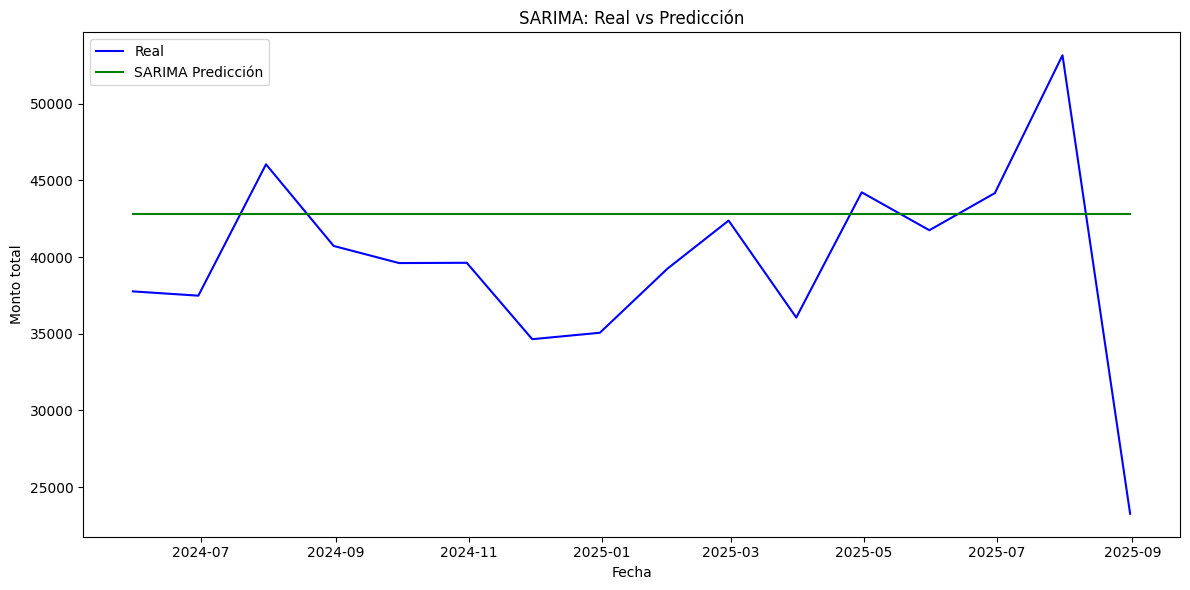

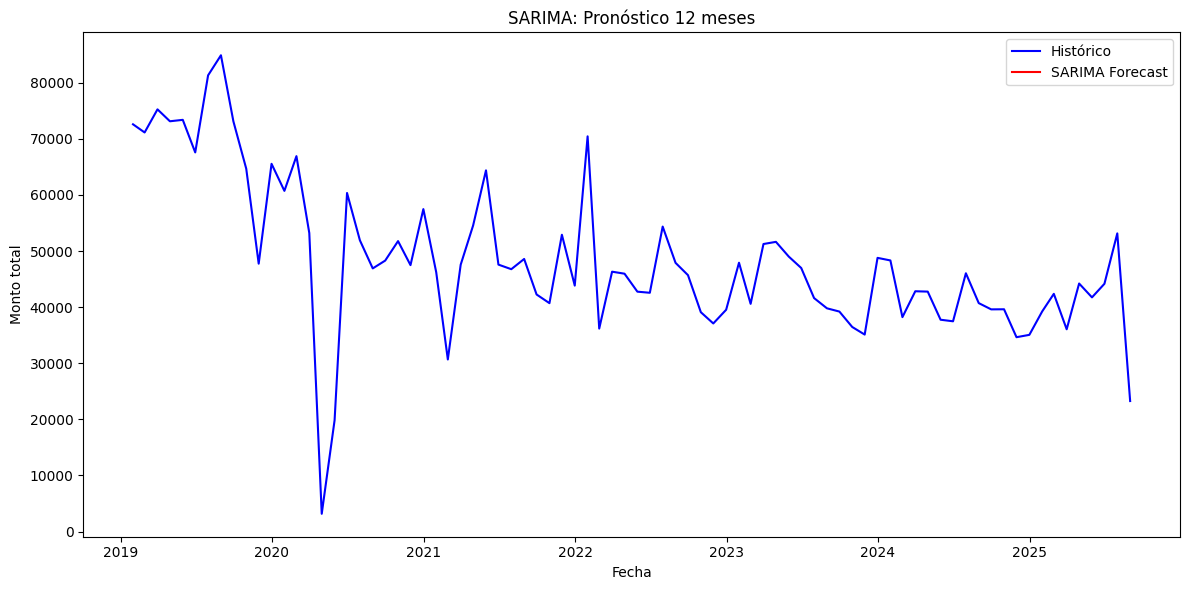

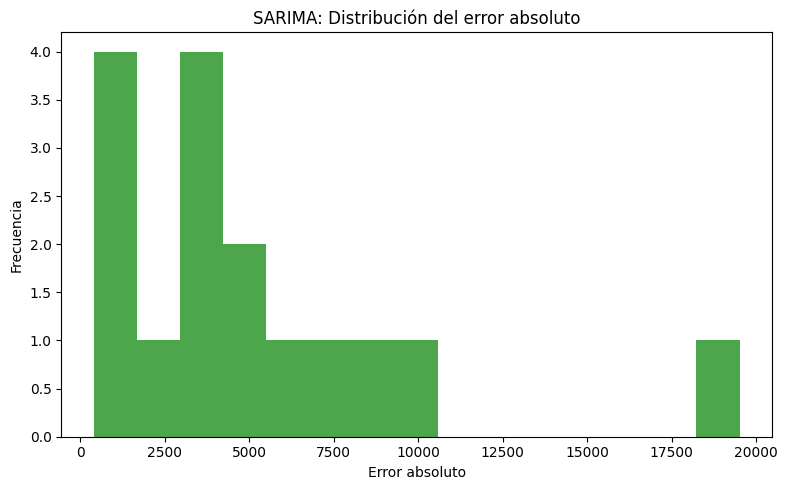

In [55]:
# a) Test set predicción vs real
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Real', color='blue')
plt.plot(y_test.index, sarima_pred, label='SARIMA Predicción', color='green')
plt.title('SARIMA: Real vs Predicción')
plt.xlabel('Fecha')
plt.ylabel('Monto total')
plt.legend()
plt.tight_layout()
plt.show()

# b) Forecast futuro
plt.figure(figsize=(12,6))
plt.plot(y.index, y, label='Histórico', color='blue')
plt.plot(sarima_forecast.index, sarima_forecast, label='SARIMA Forecast', color='red')
plt.title('SARIMA: Pronóstico 12 meses')
plt.xlabel('Fecha')
plt.ylabel('Monto total')
plt.legend()
plt.tight_layout()
plt.show()

# c) Distribución del error absoluto
errors_sarima = np.abs(y_test - sarima_pred)
plt.figure(figsize=(8,5))
plt.hist(errors_sarima, bins=15, color='green', alpha=0.7)
plt.title('SARIMA: Distribución del error absoluto')
plt.xlabel('Error absoluto')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()
